In [2]:
import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as np

from utils import *

## Feature Matching
This script identifies keypoints and generates descriptors in two images using detectors like SIFT or other options available in OpenCV. The subsequent step involves matching each keypoint in the first image with corresponding points in the second image using a brute force matcher. Specifically, for each keypoint in the first image, the script calculates the distances between the descriptors of that point and all the descriptors in the second image. The keypoint in the second image with the minimum distance is considered a match. The matches are then sorted based on distance, and the script plots the top few matches for visualization.

[Additional reading](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

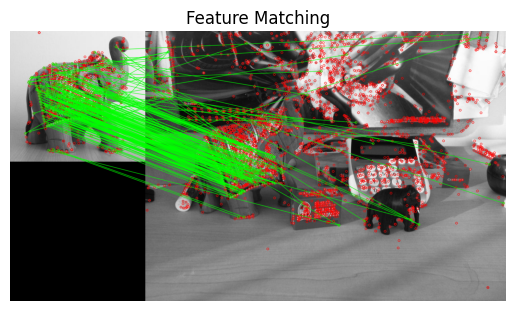

(None,)

In [7]:
# Load images
image1 = cv2.imread('data/images/elephantImage.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('data/images/sceneImage.png', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors
keypoints1, descriptors1 = feat.detectAndCompute(image1, None)
keypoints2, descriptors2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort them in ascending order of distance 
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:200], 
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, 
                              singlePointColor=(255, 0, 0), matchColor=(0, 255, 0))

# Plot the matches using Matplotlib
plt.imshow(img_matches)
plt.title('Feature Matching'),plt.axis('off')
plt.show(), 

## Feature matching with ratio test
This script performs the same keypoint detection, descriptor generation, and matching process as the previous one. However, it introduces a ratio test during the matching phase. Instead of selecting the point with the minimum distance, it considers the ratio of the distances between the best and second-best matches. If this ratio is below a certain threshold, the match is considered valid. The script then proceeds to sort and visualize the matches based on this ratio test.

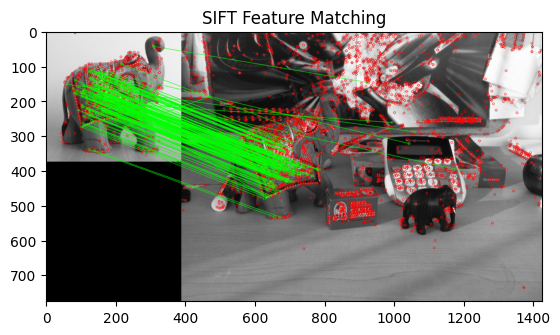

In [4]:
# Load images
image1 = cv2.imread('data/images/elephantImage.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('data/images/sceneImage.png', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors
keypoints1, descriptors1 = feat.detectAndCompute(image1, None)
keypoints2, descriptors2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1,descriptors2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Draw matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good, 
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, 
                              singlePointColor=(255, 0, 0), matchColor=(0, 255, 0))

# Plot the matches using Matplotlib
plt.imshow(img_matches)
plt.title('SIFT Feature Matching')
plt.show()

## Affine Transformation

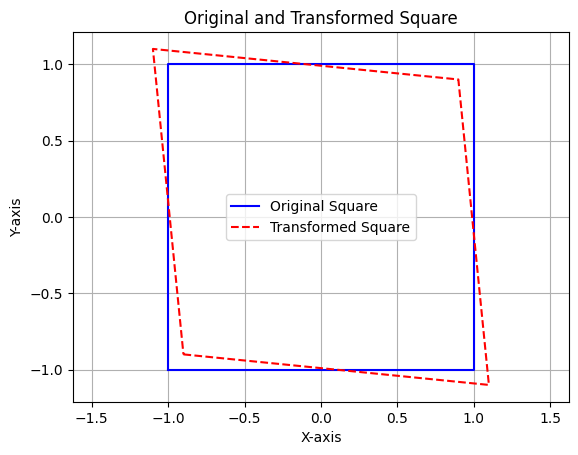

In [20]:
# Tranforming points
# Define the original square points (counter-clockwise order)
original_pts = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1], [-1, -1]]).T
original_pts = np.row_stack((original_pts, np.ones(original_pts.shape[1])))

# Plot the original square
plt.plot(original_pts[0,:], original_pts[1,:], label='Original Square', color='blue')

# transformation Matrix
scale_factor = 1
rotation_angle = 0  # in degrees
shear_factor = -.1

# Create transformation matrices
scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])

rotation_angle_rad = np.radians(rotation_angle)
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])

shear_matrix = np.array([[1, shear_factor, 0],
                        [shear_factor, 1, 0],
                        [0, 0, 1]])

# Combine the matrices to get the homography matrix
affine_matrix = np.dot(shear_matrix, np.dot(rotation_matrix, scale_matrix))

# Apply the transformation to each point
transformed_pts = np.dot(affine_matrix, original_pts)

# Plot the transformed square
plt.plot(transformed_pts[0,:], transformed_pts[1,:], label='Transformed Square', linestyle='dashed', color='red')

# Set plot properties
plt.title('Original and Transformed Square')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()


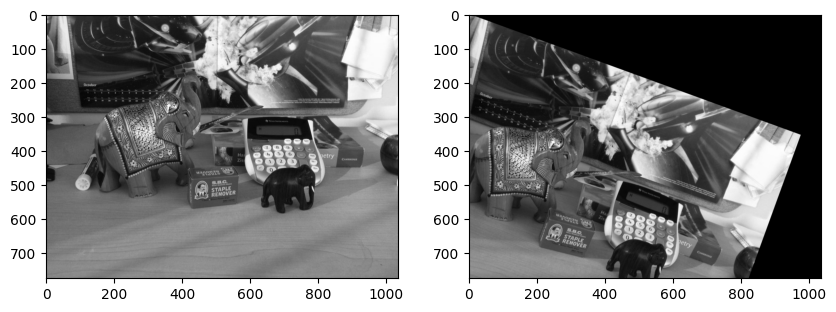

In [13]:
# Load the image
image = cv2.imread('data/images/sceneImage.png')

# Define scale, rotation, and shear factors
scale_factor = 1
rotation_angle = 20  # in degrees
shear_factor = 0

# Create transformation matrices
scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])

rotation_angle_rad = np.radians(rotation_angle)
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])

shear_matrix = np.array([[1, shear_factor, 0],
                        [shear_factor, 1, 0],
                        [0, 0, 1]])
# Combine the matrices to get the homography matrix
affine_matrix = np.dot(shear_matrix, np.dot(rotation_matrix, scale_matrix))

if 1:
    # top-left pixel is the origin
    # Apply the transformation using warpPerspective
    output_image = cv2.warpPerspective(image, affine_matrix, (image.shape[1], image.shape[0]))

else:
    # Make center of image as the origin
    T_matrix = np.array([[1, 0, image.shape[1]/2],
                     [0, 1, image.shape[0]/2],
                     [0, 0, 1]])
    affine_matrix = np.dot(np.dot(T_matrix, affine_matrix), np.linalg.inv(T_matrix))
    output_image = cv2.warpPerspective(image, affine_matrix, (image.shape[1], image.shape[0]))

# Display the original and transformed images
plt.figure(figsize = (10,8))
plt.subplot(121)
plt.imshow( image)
plt.subplot(122)
plt.imshow( output_image)

## HomographyLlinear transformation between two image planes

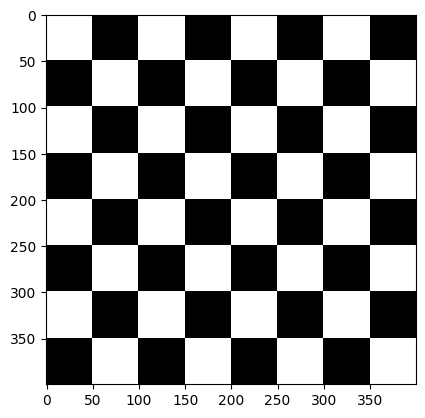

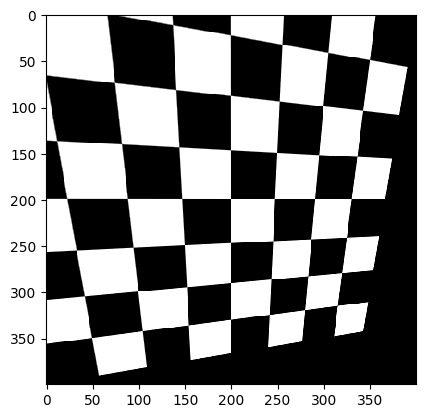

In [19]:
def create_checkerboard(rows, cols, square_size):
    checkerboard = np.zeros((rows*square_size, cols*square_size), dtype=np.uint8)

    for i in range(rows*square_size):
        for j in range(cols*square_size):
            if (i // square_size) % 2 == (j // square_size) % 2:
                checkerboard[i, j] = 255  # Set to white (255 in uint8)

    return checkerboard

rows, cols = 8, 8  # Number of rows and columns
square_size = 50   # Size of each square in pixels

checkerboard = create_checkerboard(rows, cols, square_size)

# Create a homography matrix
scale_factor = 1
rotation_angle = 0  # in degrees
# Create transformation matrices
scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])
rotation_angle_rad = np.radians(rotation_angle)
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])

# Combine the matrices to get the homography matrix
H = np.dot(rotation_matrix, scale_matrix)
H[2,:2] = np.array([0.001,0.001])
T_matrix = np.array([[1, 0, checkerboard.shape[1]/2],
                     [0, 1, checkerboard.shape[0]/2],
                     [0, 0, 1]])

H = np.dot(np.dot(T_matrix, H), np.linalg.inv(T_matrix))

# Apply the transformation using warpPerspective
output_image = cv2.warpPerspective(checkerboard, H, (checkerboard.shape[1], checkerboard.shape[0]))

# Display the checkerboard using matplotlib
plt.imshow(checkerboard, cmap='gray', interpolation='nearest')
#plt.plot(pts1[:,0], pts1[:,1],'r+')
plt.show()
plt.imsave('checkerboard1.png',checkerboard)
plt.imshow(output_image, cmap='gray', interpolation='nearest')
#plt.plot(pts2[:,0], pts2[:,1],'r+')
plt.imsave('checkerboard2.png', output_image)